## 全体の流れ
<ol>
<li>ライブラリの読み込み</li>
<li>データの整形</li>
<li>類似度行列の作成</li>
<li>クラスタリング</li>
<li>データ取得期間</li>
    ＊前４年間
<li>計測期間</li>
＊20日
<li>基準化</li>
    ＊最も低いところ
    ＊最初
    ＊全てやればいい

<li>予測手法</li>  
    ＊月次リターンが前月リターンより上昇下落 
    ＊平均の騰落率の上昇下落
</ol>

## ライブラリの読み込み

In [2]:
import pandas as pd
#from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yfinance as yf
import datetime
#from dtw import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter("ignore")
%matplotlib inline

## データ整形（変数：データ収集期間、計測期間、基準化）

In [3]:
#2012年のdata取得
start="2012-01-01"
end="2020-12-31"
# 期間を指定して株情報を取得する
df = yf.download(tickers="^TOPX",start=start,end=end,auto_adjust=True, period='1mo', interval='1d')
df=df.reset_index()
#plt.legend()
#plt.title("TOPIX:2012-2020")
#plt.plot(data["Close"])


[*********************100%***********************]  1 of 1 completed


In [4]:
#訓練データ
df_train=df[:953]
#検証データ
df_test=df[953:]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,0.990969,0.981978,0.985114,0.987187,0.978681,0.988708,0.984576,0.989219,0.996891,...,1.023823,1.036151,1.040081,1.052962,1.055855,1.048561,1.052073,1.058964,1.080714,1.077067
1,1.0,0.990927,0.994092,0.996183,0.987600,0.997718,0.993549,0.998234,1.005976,1.026063,...,1.045594,1.049560,1.062558,1.065478,1.058116,1.061661,1.068615,1.090563,1.086883,1.100736
2,1.0,1.003194,1.005304,0.996642,1.006853,1.002645,1.007374,1.015186,1.035458,1.037267,...,1.059169,1.072286,1.075233,1.067804,1.071382,1.078399,1.100548,1.096834,1.110814,1.118819
3,1.0,1.002104,0.993469,1.003648,0.999454,1.004167,1.011955,1.032162,1.033965,1.034798,...,1.068873,1.071810,1.064405,1.067971,1.074966,1.097045,1.093342,1.107278,1.115257,1.127704
4,1.0,0.991383,1.001541,0.997355,1.002059,1.009830,1.029994,1.031794,1.032626,1.046260,...,1.069560,1.062170,1.065729,1.072709,1.094742,1.091047,1.104953,1.112915,1.125336,1.130721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,1.0,0.999063,1.002734,1.001634,0.996769,0.987781,0.996945,0.997209,1.005915,1.007675,...,0.977756,0.968183,0.973940,0.960345,0.944424,0.968415,0.983494,0.966140,0.962482,0.963940
920,1.0,1.003674,1.002573,0.997704,0.988707,0.997880,0.998144,1.006858,1.008619,1.010356,...,0.969091,0.974853,0.961245,0.945309,0.969323,0.984416,0.967046,0.963384,0.964844,0.958565
921,1.0,0.998903,0.994051,0.985088,0.994227,0.994490,1.003172,1.004927,1.006657,0.999593,...,0.971285,0.957726,0.941849,0.965775,0.980813,0.963506,0.959858,0.961312,0.955056,0.958566
922,1.0,0.995143,0.986169,0.995319,0.995582,1.004273,1.006031,1.007762,1.000690,1.000552,...,0.958778,0.942883,0.966835,0.981890,0.964564,0.960912,0.962368,0.956105,0.959619,0.968511


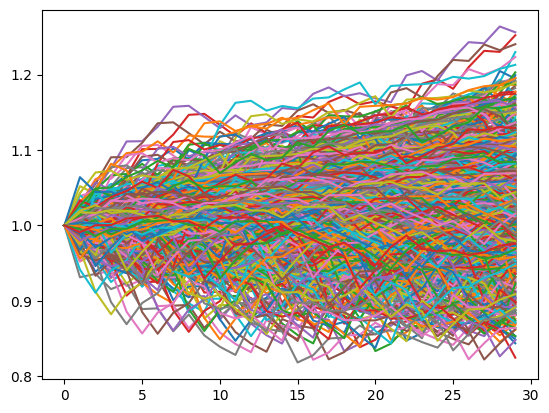

In [112]:

train_data=[]
train_close=[]
train_index=[]

#計測期間
period=30
for i in range(len(df_train)-(period-1)):
    train_data.append(df_train[i:i+period])#periodこどに分割
    train_close.append(train_data[i]["Close"])
    
    #基準化(最初)
    s=train_close[i][i]
    a=train_close[i]/s

    train_index.append(a.values)
    
    #可視化
    plt.plot(train_index[i])
df_train_index=pd.DataFrame(train_index)
df_train_index

## DTW

In [131]:
distance=[]
path=[]
for i in range(len(train_index)):
    print(f"\r{len(train_index)-i}",end="")
    for j in range(len(train_index)):
        dist,pa=fastdtw(train_index[i], train_index[j])
        distance.append(dist)
        path.append(pa)
#listの分割　
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]
 
result = list(split_list(distance, len(train_index)))
#DTW行列
c=np.array(result)
#df_c=pd.DataFrame(c)
#df_c.to_csv("train_data.csv",encoding="shift_jis")

907

KeyboardInterrupt: 

## k-medoids法 (変数：クラスタ数)

In [67]:
from sklearn_extra.cluster import KMedoids
import numpy as np
kmedoid=KMedoids(n_clusters=20, metric='euclidean', method='alternate', init='heuristic', max_iter=300, random_state=None).fit(c)
#cluster追加
df_train_index["cluster"]=kmedoid.labels_
df_train_index.groupby('cluster').count().iloc[:,0]

cluster
0      34
1      63
2      51
3      29
4      82
5      92
6      18
7      23
8      24
9     104
10     46
11     13
12     82
13     27
14     25
15     50
16     15
17     32
18     34
19     90
Name: 0, dtype: int64

## 予測手法

In [118]:
#翌月の月末価格の上昇下落ラベル

#月末終値追加
m=[]
for i in range(len(df_train)-(period-1)):
    m.append(train_data[i]["Close"].tail(1).item())
df_train_index["month_close"]=m
#目的変数Upを追加する(翌日の月末が上がる場合1、それ以外は0とする)
df_train_index['Up']=df_train_index['cluster']
for i in range(len(df_train_index['month_close'])-1):
    if df_train_index['month_close'][i] < df_train_index['month_close'][i+1]:
        df_train_index['Up'][i]="Up"
    else:
        df_train_index['Up'][i]="Down"
#最後は別途        
#if df_train_index['month_close'].tail(1) < df_train['month_close']:
#    df_train_index['Up'][i]="Up"
#else:
#    df_train_index['Up'][i]="Down"

#df = df.drop('delta_Close', axis=1)
#df_test=df_topix_index[["cluster","month_close","Up"]]

## 検証フェーズ

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,0.996714,0.986202,0.965734,0.958700,0.928647,0.955235,0.931694,0.928978,0.921003,...,0.931508,0.919943,0.906801,0.914379,0.863983,0.837905,0.792412,0.859135,0.849457,0.868534
1,1.0,0.989453,0.968918,0.961860,0.931708,0.958384,0.934765,0.932040,0.924039,0.889853,...,0.922975,0.909790,0.917393,0.866831,0.840667,0.795024,0.861967,0.852257,0.871397,0.858518
2,1.0,0.979246,0.972113,0.941639,0.968600,0.944729,0.941975,0.933888,0.899338,0.874164,...,0.919488,0.927172,0.876071,0.849628,0.803498,0.871155,0.861342,0.880686,0.867669,0.873163
3,1.0,0.992716,0.961597,0.989129,0.964752,0.961939,0.953681,0.918399,0.892691,0.942556,...,0.946822,0.894639,0.867635,0.820528,0.889618,0.879597,0.899351,0.886058,0.891669,0.885613
4,1.0,0.968652,0.996386,0.971831,0.968998,0.960679,0.925138,0.899241,0.949472,0.962213,...,0.901204,0.874002,0.826548,0.896146,0.886052,0.905950,0.892560,0.898212,0.892111,0.887523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1.0,1.016622,1.014952,1.001423,1.018233,1.019908,1.011671,1.015058,1.015634,1.036218,...,1.044338,1.047748,1.052752,1.047772,1.050582,1.053963,1.054351,1.051887,1.035466,1.037870
1148,1.0,0.998358,0.985050,1.001585,1.003233,0.995130,0.998462,0.999028,1.019276,1.022324,...,1.030618,1.035539,1.030641,1.033405,1.036731,1.037112,1.034689,1.018536,1.020901,1.026141
1149,1.0,0.986670,1.003233,1.004884,0.996768,1.000104,1.000672,1.020953,1.024006,1.034926,...,1.037243,1.032336,1.035105,1.038436,1.038819,1.036391,1.020212,1.022581,1.027829,1.035806
1150,1.0,1.016786,1.018459,1.010234,1.013615,1.014191,1.034746,1.037840,1.048907,1.030354,...,1.046283,1.049089,1.052465,1.052853,1.050393,1.033994,1.036396,1.041715,1.049800,1.068083


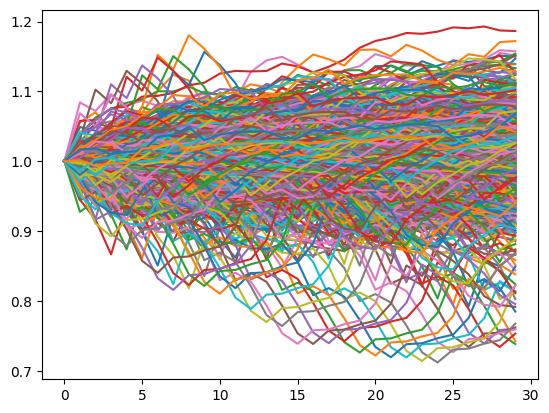

In [114]:
test_data=[]
test_close=[]
test_index=[]

#計測期間
for i in range(len(df_test)-(period-1)):
    test_data.append(df_test[i:i+period])#20日ごとに分割
    test_close.append(test_data[i]["Close"])
    
    #基準化(最初)
    s=test_close[i][953+i]
    a=test_close[i]/s

    test_index.append(a.values)
    
    #可視化
    plt.plot(test_index[i])
df_test_index=pd.DataFrame(test_index)
df_test_index

In [115]:
test_distance=[]
test_path=[]
for i in range(len(test_index)):
    print(len(test_index)-i)
    for j in range(len(train_index)):
        dist,pa=fastdtw(test_index[i], train_index[j])
        test_distance.append(dist)
        test_path.append(pa)
#listの分割　
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]
 

test_result = list(split_list(test_distance,len(train_index)))
#DTW行列
test_c=np.array(test_result)
#df_c=pd.DataFrame(c,index=datas,columns=datas)
#df_c.to_csv("dtw.csv",encoding="shift_jis")

1152
1151
1150
1149
1148
1147
1146
1145
1144
1143
1142
1141
1140
1139
1138
1137
1136
1135
1134
1133
1132
1131
1130
1129
1128
1127
1126
1125
1124
1123
1122
1121
1120
1119
1118
1117
1116
1115
1114
1113
1112
1111
1110
1109
1108
1107
1106
1105
1104
1103
1102
1101
1100
1099
1098
1097
1096
1095
1094
1093
1092
1091
1090
1089
1088
1087
1086
1085
1084
1083
1082
1081
1080
1079
1078
1077
1076
1075
1074
1073
1072
1071
1070
1069
1068
1067
1066
1065
1064
1063
1062
1061
1060
1059
1058
1057
1056
1055
1054
1053
1052
1051
1050
1049
1048
1047
1046
1045
1044
1043
1042
1041
1040
1039
1038
1037
1036
1035
1034
1033
1032
1031
1030
1029
1028
1027
1026
1025
1024
1023
1022
1021
1020
1019
1018
1017
1016
1015
1014
1013
1012
1011
1010
1009
1008
1007
1006
1005
1004
1003
1002
1001
1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941

In [69]:
#距離に基づき過去の株価変動パターンが近い月を順にn個選ぶ→クラスタリング,勾配降下法,動的計画法
#k-medoids法 
test_kmedoid=KMedoids(n_clusters=20, 
                       metric='euclidean', 
                       method='alternate', 
                       init='heuristic', 
                       max_iter=300, 
                       random_state=None).fit(test_c)
#cluster追加
df_test_index["cluster"]=test_kmedoid.labels_
group=df_test_index.groupby('cluster').count().iloc[:,1]
group

cluster
0     149
1     154
2      87
3      29
4      31
5      18
6      13
7      26
8      78
9      17
10    134
11     94
12     18
13     36
14      9
15     57
16     23
17     56
18     30
19    103
Name: 1, dtype: int64

In [116]:
df_train_index.groupby(["cluster",'Up']).count().iloc[:,1]
df_test_index.groupby(["cluster",'Up']).count().iloc[:,1]

KeyError: 'cluster'

In [93]:
len(df_test_index)

1162

In [119]:
#翌月の月末価格の上昇下落ラベル

#月末終値追加
n=[]
for i in range(len(df_test)-(period-1)):
    n.append(test_data[i]["Close"].tail(1).item())
df_test_index["month_close"]=n
#目的変数Upを追加する(翌日の月末が上がる場合1、それ以外は0とする)
df_test_index['Up']=df_test_index['cluster']
for i in range(len(df_test_index['month_close'])-1):
    if df_test_index['month_close'][i] < df_test_index['month_close'][i+1]:
        df_test_index['Up'][i]="Up"
    else:
        df_test_index['Up'][i]="Down"
#最後は別途        
#if df_train_index['month_close'].tail(1) < df_train['month_close']:
#    df_train_index['Up'][i]="Up"
#else:
#    df_train_index['Up'][i]="Down"

#df = df.drop('delta_Close', axis=1)
#df_test=df_topix_index[["cluster","month_close","Up"]]

In [96]:
from sklearn_extra.cluster import KMedoids
import numpy as np
k=30
kmedoid=KMedoids(n_clusters=k, metric='euclidean', method='alternate', init='heuristic', max_iter=300, random_state=None).fit(c)
#cluster追加
df_train_index["cluster"]=kmedoid.labels_
df_train_index.groupby('cluster').count().iloc[:,0]

#距離に基づき過去の株価変動パターンが近い月を順にn個選ぶ→クラスタリング,勾配降下法,動的計画法
#k-medoids法 
test_kmedoid=KMedoids(n_clusters=k, 
                       metric='euclidean', 
                       method='alternate', 
                       init='heuristic', 
                       max_iter=300, 
                       random_state=None).fit(test_c)
#cluster追加
df_test_index["cluster"]=test_kmedoid.labels_
group=df_test_index.groupby('cluster').count().iloc[:,1]
group

cluster
0     147
1      38
2       2
3       2
4      21
5       3
6       1
7      20
8       9
9       5
10     18
11      3
12      9
13      2
14      3
15      1
16     15
17     19
18     15
19     69
20     87
21     37
22     74
23     40
24     27
25    149
26     17
27     59
28    109
29    161
Name: 1, dtype: int64

In [95]:
if df_test_index["cluster"][0]==28:#cluster 特定
        q=df_train_index[df_train_index["cluster"]==28]
        up=(q["Up"]=="Up").sum()
        down=(q["Up"]=="Down").sum()
        print(up)
        print(down)

60
49


In [121]:
df_test_index["Pred_Up"]=df_test_index["cluster"]

In [122]:
from sklearn_extra.cluster import KMedoids
ks=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
for k in ks:
    kmedoid=KMedoids(n_clusters=k, metric='euclidean', method='alternate', init='heuristic', max_iter=300, random_state=None).fit(c)
    #cluster追加
    df_train_index["cluster"]=kmedoid.labels_
    df_train_index.groupby('cluster').count().iloc[:,0]

    #距離に基づき過去の株価変動パターンが近い月を順にn個選ぶ→クラスタリング,勾配降下法,動的計画法
    #k-medoids法 
    test_kmedoid=KMedoids(n_clusters=k, 
                        metric='euclidean', 
                        method='alternate', 
                        init='heuristic', 
                        max_iter=300, 
                        random_state=None).fit(test_c)
    #cluster追加
    df_test_index["cluster"]=test_kmedoid.labels_
    group=df_test_index.groupby('cluster').count().iloc[:,1]
    group
    for i in range(len(df_test_index)):#test回数分
        for j in range(k):#cluster回数分
            if df_test_index["cluster"][i]==j:#cluster 特定
                q=df_train_index[df_train_index["cluster"]==j]
                up=(q["Up"]=="Up").sum()
                down=(q["Up"]=="Down").sum()
                if up>down:
                    df_test_index["Pred_Up"][i]="Up"
                    #position=df_test_index["month_close"][i]
                    #rikaku=df_test_index["month_close"][i+1]
                    #profit=rikaku-position
                    #month_return=(rikaku/position)
                elif up<down:
                    df_test_index["Pred_Up"][i]="Down"
                    #position=df_test_index["month_close"][i]
                    #rikaku=df_test_index["month_close"][i+1]
                    #profit=position-rikaku
                    #month_return=(position/rikaku)

    acc=0
    bunbo=0
    for i in range(len(df_test_index)):
        if df_test_index["Pred_Up"][i]=="Up" or df_test_index["Pred_Up"][i]=="Down":
            bunbo=bunbo+1
            if df_test_index["Pred_Up"][i]==df_test_index["Up"][i]:
                acc=acc+1
    #print("累積収益率：",100+ruiseki_return,"%")
    print("正解率：",(acc/bunbo)*100,"%")

正解率： 51.47569444444444 %
正解率： 52.083333333333336 %
正解率： 50.520833333333336 %
正解率： 52.083333333333336 %
正解率： 50.954861111111114 %
正解率： 52.864583333333336 %
正解率： 51.64930555555556 %
正解率： 48.95833333333333 %
正解率： 51.47569444444444 %
正解率： 49.21875 %
正解率： 48.87152777777778 %
正解率： 50.08680555555556 %
正解率： 50.520833333333336 %
正解率： 50.78125 %
正解率： 49.65277777777778 %
正解率： 50.69444444444444 %
正解率： 50.173611111111114 %
正解率： 50.0 %
正解率： 53.21180555555556 %
正解率： 50.954861111111114 %
正解率： 52.170138888888886 %
正解率： 50.08680555555556 %
正解率： 51.12847222222222 %
正解率： 49.91319444444444 %
正解率： 49.65277777777778 %
正解率： 51.47569444444444 %
正解率： 51.041666666666664 %
正解率： 50.34722222222222 %
正解率： 49.56597222222222 %
正解率： 50.34722222222222 %
正解率： 50.607638888888886 %
正解率： 48.52430555555556 %
正解率： 50.69444444444444 %
正解率： 52.604166666666664 %
正解率： 51.041666666666664 %
正解率： 51.5625 %


In [110]:
acc=0
bunbo=0
for i in range(len(df_test_index)):
    if df_test_index["Pred_Up"][i]=="Up" or df_test_index["Pred_Up"][i]=="Down":
        bunbo=bunbo+1
        if df_test_index["Pred_Up"][i]==df_test_index["Up"][i]:
            acc=acc+1
#print("累積収益率：",100+ruiseki_return,"%")
print("正解率：",(acc/bunbo)*100,"%")

正解率： 51.29087779690189 %


In [111]:
df_test["Pred_Up"]=df_test["Up"]
touti=1

#正解ラベルの付与
for j in range(30):#クラスタ数回
    if df_test_index["cluster"][i]==j:#クラスタ数の特定
    #クラスタ内の上昇（下落）ラベルの多数決
        n=df_topix_tests[df_topix_tests["cluster"]==j]
        n.reset_index(inplace=True)
        n["Time"] = pd.to_datetime(n["index"])
        up=int((n['Up']=="up").sum())#上昇ラベルの総数
        down=int((n["Up"]=="down").sum())#下落ラベルの総数
if up-down>=touti:#上昇ラベルの方が多い場合
    #df_test_MinMax_close["pred_Up"]=df_test_MinMax_close["cluster"]
    df_test_MinMax_close["pred_Up"][i]="up"
    position=df_test_MinMax_close["month_close"][i]#月末価格で購入
    #m_date=(n["Time"][j]+relativedelta(months=+1)).strftime('%Y-%m-%d')
    #m_date=pd.to_datetime(m_date)
    #df_test_MinMax_close.reset_index(inplace=True)
    #df_test_MinMax_close["Time"] = pd.to_datetime(df_test_MinMax_close.index)
    #n.set_index("index", inplace = True)
    #df_test_MinMax_close["Time"][0]+relativedelta(months=+1)
    #df_train["month_close"][df_train["Time"] [0] +relativedelta(months=+1).fromtimestamp(ts)]
    rikaku=df_test_MinMax_close["month_close"][i+1]#翌月価格
    profit=rikaku-position#翌月価格で売った時の収益
    month_return=(rikaku/position)#リターン％
    return_graph.append(month_return)
    ruiseki_return=(ruiseki_return+month_return)#累積収益率
    print(ruiseki_return)
    #sum=sum+profit#利益の合計
    #print("利益=",sum)
#s.append(sum)#毎月の利益
elif up-down>=touti:
    #df_test_MinMax_close["pred_Up"]=df_test_MinMax_close["cluster"]
    df_test_MinMax_close["pred_Up"][i]="down"
    position=df_test_MinMax_close["month_close"][i]#月末価格で売却
    #df_test_MinMax_close["Time"] = pd.to_datetime(df_test_MinMax_close.index
    rikaku=df_test_MinMax_close["month_close"][i+1]#翌月価格
    profit=position-rikaku#翌月価格で買った時の収益
    month_return=(rikaku/position)#リターン％
    return_graph.append(month_return)
    ruiseki_return=(ruiseki_return+month_return)#累積収益率
    print(ruiseki_return)
#ruiseki_return=(1+month_return).cumprod()#累積収益率
#sum=sum+profit#利益の合計
#print("利益=",sum)
#s.append(sum)

#結果
acc=0
bunbo=0
for i in range(60):
    if df_test_MinMax_close["pred_Up"][i]=="up" or df_test_MinMax_close["pred_Up"][i]=="down":
        bunbo=bunbo+1
        if df_test_MinMax_close["pred_Up"][i]==df_test_MinMax_close["Up"][i]:
            acc=acc+1
print("累積収益率：",100+ruiseki_return,"%")
print("正解率：",(acc/bunbo)*100,"%")

216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [237]:
df_train=pd.DataFrame(train_data)
df_test=pd.DataFrame(test_data)
df_train["Adj Close"]=monthly_data["Adj Close"][:216]
df_test["Adj Close"]=monthly_data["Adj Close"][216:]

In [148]:
#listの分割　
def split_list(l, n):
    """
    #リストをサブリストに分割する
    #:param l: リスト
    #:param n: サブリストの要素数
    #:return: 
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]
 
result = list(split_list(distance, len(train_data)))
#DTW行列
c=np.array(result)
#df_c=pd.DataFrame(c)
#df_c.to_csv("train_data.csv",encoding="shift_jis")
#k-medoids法
from sklearn_extra.cluster import KMedoids


In [238]:
kmedoid=KMedoids(n_clusters=30, metric='euclidean', method='pam', init='heuristic', max_iter=300, random_state=None).fit(c)
#cluster追加
df_train["cluster"]=kmedoid.labels_
df_train.groupby('cluster').count().iloc[:,0]

cluster
0      9
1      6
2      1
3     12
4      6
5      2
6      9
7      2
8      1
9     10
10    11
11     7
12     6
13    13
14     7
15     4
16     3
17     2
18     3
19     1
20    16
21    15
22     5
23     9
24     1
25    14
26    11
27     9
28    13
29     8
Name: Adj Close_index, dtype: int64

In [255]:
#月末価格
df_train["Month_Close"]=df_train["Adj Close"]
for i in range(len(df_train)):
    df_train["Month_Close"][i] = df_train["Adj Close"][i][-1]

#上昇下落ラベル付与
df_train["Up"]=df_train["cluster"]
for i in range(len(df_train)-1):
    if df_train["Month_Close"][i]<df_train["Month_Close"][i+1]:
        df_train["Up"][i]="up"
    else:
        df_train["Up"][i]="down"
#最後は個別で
if df_test["Adj Close"][0][-1]>df_train["Month_Close"][-1]:
    df_train["Up"][-1]="up"
else:
    df_train["Up"][-1]="down"


In [256]:
df_train

,Adj Close_index,Adj Close,cluster,Month_Close,Up
Date,,,,,
1989-01-31,"[1.0, 0.9969688245594794, 0.9964635430001699, ...","[2375.300048828125, 2368.10009765625, 2366.899...",26,2464.800049,down
1989-02-28,"[1.0, 1.0046214078099835, 1.0083841148342558, ...","[2445.10009765625, 2456.39990234375, 2465.6000...",28,2447.199951,up
1989-03-31,"[1.0, 0.9995498413805264, 0.9984040648144494, ...","[2443.800048828125, 2442.699951171875, 2439.89...",21,2469.199951,up
1989-04-30,"[1.0, 1.0062816616008106, 1.0110232831496961, ...","[2467.5, 2483.0, 2494.699951171875, 2469.80004...",29,2488.5,up
1989-05-31,"[1.0, 1.005672492667638, 1.0164982415301989, 1...","[2503.300048828125, 2517.5, 2544.60009765625, ...",28,2537.100098,down
...,...,...,...,...,...
2006-08-31,"[1.0, 1.0016847465121377, 1.0016081706661382, ...","[1567.010009765625, 1569.6500244140625, 1569.5...",26,1634.459961,down
2006-09-30,"[1.0, 1.011020295875991, 1.0057978821714115, 0...","[1633.3499755859375, 1651.3499755859375, 1642....",20,1610.72998,up
2006-10-31,"[1.0, 0.995520312765366, 0.9857672018359822, 1...","[1625.1199951171875, 1617.8399658203125, 1601....",28,1617.420044,down


<h1>検証フェーズ</h1>

In [259]:
df_test

,Adj Close_index,Adj Close
Date,,
2007-01-31,"[1.0, 0.9860972978627798, 0.9959798956702778, ...","[1698.949951171875, 1675.3299560546875, 1692.1..."
2007-02-28,"[1.0, 1.0021972347869716, 0.9871734821972656, ...","[1738.5799560546875, 1742.4000244140625, 1716...."
2007-03-31,"[1.0, 0.9893569833590098, 0.9555200389253412, ...","[1740.1099853515625, 1721.5899658203125, 1662...."
2007-04-30,"[1.0, 1.0129747910426774, 1.0285469925976702, ...","[1682.489990234375, 1704.3199462890625, 1730.5..."
2007-05-31,"[1.0, 1.0064786479864904, 1.0234932994518677, ...","[1693.25, 1704.219970703125, 1733.030029296875..."
...,...,...
2016-08-31,"[1.0, 0.9836363181332549, 0.9622871494494447, ...","[1321.8299560546875, 1300.199951171875, 1271.9..."
2016-09-30,"[1.0, 1.0025273331966023, 1.0113654691384495, ...","[1337.3800048828125, 1340.760009765625, 1352.5..."
2016-10-31,"[1.0, 1.0071314705146874, 1.0128427379665723, ...","[1330.719970703125, 1340.2099609375, 1347.8100..."


In [270]:
test_distance=[]
test_path=[]
#DTW
for i in range(len(test_data)):#テストデータ数分繰り返す 2016-01-01から2020-12-01までの60ヵ月分
    #topix_test.append(test_MinMax_close[i])#学習データに追加
    print(len(test_data)-i)
    for j in range(len(train_data)):#データ数分繰り返す1038
        test_dist,test_pa=fastdtw(test_data[i], train_data[j])
        test_distance.append(test_dist)
        test_path.append(test_pa)
test_result = list(split_list(test_distance,len(train_data)))

120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [282]:
train_data

Date
1989-01-31    [1.0, 0.9969688245594794, 0.9964635430001699, ...
1989-02-28    [1.0, 1.0046214078099835, 1.0083841148342558, ...
1989-03-31    [1.0, 0.9995498413805264, 0.9984040648144494, ...
1989-04-30    [1.0, 1.0062816616008106, 1.0110232831496961, ...
1989-05-31    [1.0, 1.005672492667638, 1.0164982415301989, 1...
                                    ...                        
2006-08-31    [1.0, 1.0016847465121377, 1.0016081706661382, ...
2006-09-30    [1.0, 1.011020295875991, 1.0057978821714115, 0...
2006-10-31    [1.0, 0.995520312765366, 0.9857672018359822, 1...
2006-11-30    [1.0, 0.9978490177481992, 0.9964252616050345, ...
2006-12-31    [1.0, 1.0017695593352298, 0.9962552123657552, ...
Freq: M, Name: Adj Close_index, Length: 216, dtype: object

In [307]:
test_distance=[]
test_path=[]
#DTW
for i in range(len(test_data)):#120
    print(len(test_data)-i)
    for j in range(len(train_data)):#216.217.218...
        test_dist,test_pa=fastdtw(test_data[i], train_data[j])
        test_distance.append(test_dist)
        test_path.append(test_pa)
    # リストの要素を持つDataFrameを作成
    train_df = pd.DataFrame({'data': train_data.values.tolist()}, index=train_data.index)
    train_df
    # 新しいデータを追加
    new_df = pd.DataFrame({'data': test_data.tolist()}, index=test_data.index)
    train_df = pd.concat([train_df, new_df["data"]], axis=1)

    # DataFrameをSeriesに変換
    df_train = pd.Series(train_df['data'].values.tolist(), index=train_df.index)

120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [309]:
df_train

Date
1989-01-31    [[1.0, 0.9969688245594794, 0.9964635430001699,...
1989-02-28    [[1.0, 1.0046214078099835, 1.0083841148342558,...
1989-03-31    [[1.0, 0.9995498413805264, 0.9984040648144494,...
1989-04-30    [[1.0, 1.0062816616008106, 1.0110232831496961,...
1989-05-31    [[1.0, 1.005672492667638, 1.0164982415301989, ...
                                    ...                        
2016-08-31    [nan, [1.0, 0.9836363181332549, 0.962287149449...
2016-09-30    [nan, [1.0, 1.0025273331966023, 1.011365469138...
2016-10-31    [nan, [1.0, 1.0071314705146874, 1.012842737966...
2016-11-30    [nan, [1.0, 0.9822350138596192, 0.966874651494...
2016-12-31    [nan, [1.0, 0.996433529301582, 0.9890039855326...
Freq: M, Length: 336, dtype: object

In [294]:
# リストの要素を持つDataFrameを作成
train_df = pd.DataFrame({'data': train_data.values.tolist()}, index=train_data.index)
train_df
# 新しいデータを追加
new_df = pd.DataFrame({'data': test_data.tolist()}, index=test_data.index)
train_df = pd.concat([train_df, new_df], axis=0)

# DataFrameをSeriesに変換
df_train = pd.Series(train_df['data'].values.tolist(), index=train_df.index)

Date
1989-01-31    [1.0, 0.9969688245594794, 0.9964635430001699, ...
1989-02-28    [1.0, 1.0046214078099835, 1.0083841148342558, ...
1989-03-31    [1.0, 0.9995498413805264, 0.9984040648144494, ...
1989-04-30    [1.0, 1.0062816616008106, 1.0110232831496961, ...
1989-05-31    [1.0, 1.005672492667638, 1.0164982415301989, 1...
                                    ...                        
2016-08-31    [1.0, 0.9836363181332549, 0.9622871494494447, ...
2016-09-30    [1.0, 1.0025273331966023, 1.0113654691384495, ...
2016-10-31    [1.0, 1.0071314705146874, 1.0128427379665723, ...
2016-11-30    [1.0, 0.9822350138596192, 0.9668746514942769, ...
2016-12-31    [1.0, 0.996433529301582, 0.9890039855326515, 0...
Freq: M, Length: 336, dtype: object

In [271]:
test_result = list(split_list(test_distance,len(train_data)))
#DTW行列
test_c=np.array(test_result)
#df_c=pd.DataFrame(c,index=datas,columns=datas)
#df_c.to_csv("dtw.csv",encoding="shift_jis")


#距離に基づき過去の株価変動パターンが近い月を順にn個選ぶ→クラスタリング,勾配降下法,動的計画法
#k-medoids法 
test_kmedoid=KMedoids(n_clusters=30, 
                       metric='euclidean', 
                       method='alternate', 
                       init='heuristic', 
                       max_iter=300, 
                       random_state=None).fit(test_c)
#cluster追加
df_test["cluster"]=test_kmedoid.labels_
#df_test_MinMax_close.groupby('cluster').count().iloc[:,1]

In [272]:
df_test

,Adj Close_index,Adj Close,cluster
Date,,,
2007-01-31,"[1.0, 0.9860972978627798, 0.9959798956702778, ...","[1698.949951171875, 1675.3299560546875, 1692.1...",17
2007-02-28,"[1.0, 1.0021972347869716, 0.9871734821972656, ...","[1738.5799560546875, 1742.4000244140625, 1716....",18
2007-03-31,"[1.0, 0.9893569833590098, 0.9555200389253412, ...","[1740.1099853515625, 1721.5899658203125, 1662....",0
2007-04-30,"[1.0, 1.0129747910426774, 1.0285469925976702, ...","[1682.489990234375, 1704.3199462890625, 1730.5...",28
2007-05-31,"[1.0, 1.0064786479864904, 1.0234932994518677, ...","[1693.25, 1704.219970703125, 1733.030029296875...",23
...,...,...,...
2016-08-31,"[1.0, 0.9836363181332549, 0.9622871494494447, ...","[1321.8299560546875, 1300.199951171875, 1271.9...",0
2016-09-30,"[1.0, 1.0025273331966023, 1.0113654691384495, ...","[1337.3800048828125, 1340.760009765625, 1352.5...",27
2016-10-31,"[1.0, 1.0071314705146874, 1.0128427379665723, ...","[1330.719970703125, 1340.2099609375, 1347.8100...",23


In [273]:
#月末価格
df_test["Month_Close"]=df_test["Adj Close"]
for i in range(len(df_test)):
    df_test["Month_Close"][i] = df_test["Adj Close"][i][-1]

#上昇下落ラベル付与
df_test["Up"]=df_test["cluster"]
for i in range(len(df_test)-1):
    if df_test["Month_Close"][i]<df_test["Month_Close"][i+1]:
        df_test["Up"][i]="up"
    else:
        df_test["Up"][i]="down"
#最後は個別で
if df_test["Adj Close"][0][-1]>df_test["Month_Close"][-1]:
    df_test["Up"][-1]="up"
else:
    df_test["Up"][-1]="down"


In [274]:
df_test

,Adj Close_index,Adj Close,cluster,Month_Close,Up
Date,,,,,
2007-01-31,"[1.0, 0.9860972978627798, 0.9959798956702778, ...","[1698.949951171875, 1675.3299560546875, 1692.1...",17,1721.959961,up
2007-02-28,"[1.0, 1.0021972347869716, 0.9871734821972656, ...","[1738.5799560546875, 1742.4000244140625, 1716....",18,1752.73999,down
2007-03-31,"[1.0, 0.9893569833590098, 0.9555200389253412, ...","[1740.1099853515625, 1721.5899658203125, 1662....",0,1713.609985,down
2007-04-30,"[1.0, 1.0129747910426774, 1.0285469925976702, ...","[1682.489990234375, 1704.3199462890625, 1730.5...",28,1701.0,up
2007-05-31,"[1.0, 1.0064786479864904, 1.0234932994518677, ...","[1693.25, 1704.219970703125, 1733.030029296875...",23,1755.680054,up
...,...,...,...,...,...
2016-08-31,"[1.0, 0.9836363181332549, 0.9622871494494447, ...","[1321.8299560546875, 1300.199951171875, 1271.9...",0,1329.540039,down
2016-09-30,"[1.0, 1.0025273331966023, 1.0113654691384495, ...","[1337.3800048828125, 1340.760009765625, 1352.5...",27,1322.780029,up
2016-10-31,"[1.0, 1.0071314705146874, 1.0128427379665723, ...","[1330.719970703125, 1340.2099609375, 1347.8100...",23,1393.02002,up


In [175]:

df_test["Pred_Up"]=df_test["Up"]
touti=1

#正解ラベルの付与
    for j in range(30):#クラスタ数回
        if df_test_MinMax_close["cluster"][i]==j:#クラスタ数の特定
        #クラスタ内の上昇（下落）ラベルの多数決
            n=df_topix_tests[df_topix_tests["cluster"]==j]
            n.reset_index(inplace=True)
            n["Time"] = pd.to_datetime(n["index"])
            up=int((n['Up']=="up").sum())#上昇ラベルの総数
            down=int((n["Up"]=="down").sum())#下落ラベルの総数
    if up-down>=touti:#上昇ラベルの方が多い場合
        #df_test_MinMax_close["pred_Up"]=df_test_MinMax_close["cluster"]
        df_test_MinMax_close["pred_Up"][i]="up"
        position=df_test_MinMax_close["month_close"][i]#月末価格で購入
        #m_date=(n["Time"][j]+relativedelta(months=+1)).strftime('%Y-%m-%d')
        #m_date=pd.to_datetime(m_date)
        #df_test_MinMax_close.reset_index(inplace=True)
        #df_test_MinMax_close["Time"] = pd.to_datetime(df_test_MinMax_close.index)
        #n.set_index("index", inplace = True)
        #df_test_MinMax_close["Time"][0]+relativedelta(months=+1)
        #df_train["month_close"][df_train["Time"] [0] +relativedelta(months=+1).fromtimestamp(ts)]
        rikaku=df_test_MinMax_close["month_close"][i+1]#翌月価格
        profit=rikaku-position#翌月価格で売った時の収益
        month_return=(rikaku/position)#リターン％
        return_graph.append(month_return)
        ruiseki_return=(ruiseki_return+month_return)#累積収益率
        print(ruiseki_return)
        #sum=sum+profit#利益の合計
        #print("利益=",sum)
    #s.append(sum)#毎月の利益
    elif up-down>=touti:
        #df_test_MinMax_close["pred_Up"]=df_test_MinMax_close["cluster"]
        df_test_MinMax_close["pred_Up"][i]="down"
        position=df_test_MinMax_close["month_close"][i]#月末価格で売却
        #df_test_MinMax_close["Time"] = pd.to_datetime(df_test_MinMax_close.index
        rikaku=df_test_MinMax_close["month_close"][i+1]#翌月価格
        profit=position-rikaku#翌月価格で買った時の収益
        month_return=(rikaku/position)#リターン％
        return_graph.append(month_return)
        ruiseki_return=(ruiseki_return+month_return)#累積収益率
        print(ruiseki_return)
    #ruiseki_return=(1+month_return).cumprod()#累積収益率
    #sum=sum+profit#利益の合計
    #print("利益=",sum)
#s.append(sum)

#結果
acc=0
bunbo=0
for i in range(60):
    if df_test_MinMax_close["pred_Up"][i]=="up" or df_test_MinMax_close["pred_Up"][i]=="down":
        bunbo=bunbo+1
        if df_test_MinMax_close["pred_Up"][i]==df_test_MinMax_close["Up"][i]:
            acc=acc+1
print("累積収益率：",100+ruiseki_return,"%")
print("正解率：",(acc/bunbo)*100,"%")

0.9057262569832403
1.9442767581397553
2.939080024657944
3.9681845022698843
5.030031891828117
6.035326899392414
7.030059781258479
8.083766286553487
9.1383247933733
10.171680817879768
11.173657102464748
12.1586733891097
13.171239526675837
14.195406737649057
15.23065720147095
16.285018013896277
17.300315464321205
18.3107722612392
19.29388987519531
20.30718467288317
21.29691656107484
22.20280538881287
23.215563590513963
24.111784346362793
25.160646461489968
26.186172945216835
27.17621650464434
28.192558427963007
29.127623363027944
30.153417013821596
31.162443448379946
32.127938656047675
33.17823647206356
34.228646049883345
35.24784221065119
36.176981283498876
37.24460423431855
38.24140525799098
39.24573158679196
40.27423785817167
累積収益率： 140.27423785817166 %
正解率： 67.5 %


In [174]:
bunbo

7

In [172]:
acc=0
bunbo=0
for i in range(60):
    if df_test_MinMax_close["pred_Up"][i]=="up" or df_test_MinMax_close["pred_Up"][i]=="down":
        bunbo=bunbo+1
        if df_test_MinMax_close["pred_Up"][i]==df_test_MinMax_close["Up"][i]:
            acc=acc+1
print("累積収益率：",100+ruiseki_return,"%")
print("正解率：",(acc/bunbo)*100,"%")

累積収益率： 106.88579980468658 %
正解率： 42.857142857142854 %


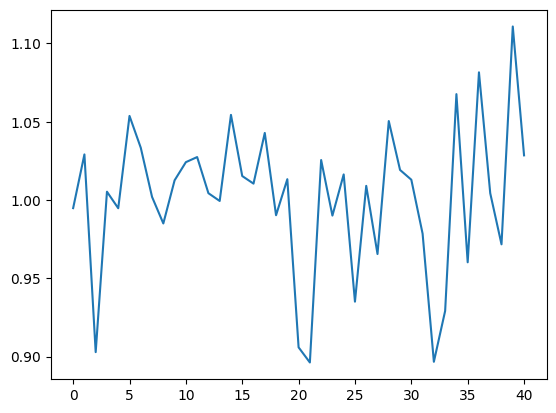

In [105]:
plt.plot(return_graph)

In [ ]:
#変動率
#テクニカル指標
#月、週、日単位の平均、標準偏差
#移動平均線のパターン分析
#トレンド・季節性・周期性・不規則性→不規則性を削除もしくは不規則性のトレンドのみに適用

In [ ]:
# 終値の前日比の追加
df_shift = df.shift(1)

df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

# 始値と終値の差分を追加
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
1965-01-05,0,1,1.163391e+05,1.163391e+05,1.163391e+05,1.163391e+05,1,NaN
1965-01-06,0,2,1.169191e+05,1.169191e+05,1.169191e+05,1.169191e+05,1,0.004985
1965-01-07,0,3,1.178700e+05,1.178700e+05,1.178700e+05,1.178700e+05,1,0.008133
1965-01-08,0,4,1.189948e+05,1.189948e+05,1.189948e+05,1.189948e+05,1,0.009543
1965-01-12,1,1,1.191900e+05,1.191900e+05,1.191900e+05,1.191900e+05,0,0.001640
...,...,...,...,...,...,...,...,...
2021-10-15,2962,4,2.690117e+06,2.657175e+06,2.662822e+06,2.688848e+06,0,0.018133
2021-10-18,2963,0,2.695851e+06,2.675507e+06,2.691178e+06,2.684855e+06,1,-0.001485
2021-10-19,2963,1,2.707705e+06,2.689472e+06,2.693348e+06,2.702436e+06,1,0.006548


## 検証データによる予測と精度検証

In [ ]:
#参考文献
k-medoids
#https://python-kmedoids.readthedocs.io/en/latest/